In [1]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()


/home/ubuntu/audio-dnn-demo/train/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/audio-dnn-demo/train/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/audio-dnn-demo/train/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/audio-dnn-demo/

2.0.0-alpha0


'/device:GPU:0'

In [2]:
import pandas as pd 
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

# from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

import seaborn as sns

In [3]:
# img_rows, img_cols= 28, 28
# batch_size = 128
# epochs = 1
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
# x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# input_shape = (img_rows, img_cols, 1)
# x_train.shape

In [4]:
from collect_data import load_data
(x_train, y_train), (x_test, y_test)= load_data()


--------------- ../data/1-308_AUDIO/spectrograms/ 1 ---------------

--------------- ../data/0-300_AUDIO/spectrograms/ 0 ---------------
x_train.shape (21, 512, 71)
y_train.shape (21,)
x_test.shape (11, 512, 71)
y_test.shape (11,)


In [5]:
img_rows, img_cols= 512, 71
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [6]:
batch_size = 32
epochs = 3

In [7]:
def cnn(x_train, y_train, x_test, y_test, batch_size, epochs, input_shape):
    nb_classes= 2
    L_weight= 0.01
    
    model = Sequential()
    model.add( Conv2D(32, (3, 3), padding='valid', strides=1, 
                     kernel_constraint=max_norm(3), bias_constraint=max_norm(3),
                     bias_regularizer=l2(L_weight),
                     input_shape=input_shape, activation='relu'))
    
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))
    
    model.add( Conv2D(32, (3, 3), padding='valid', strides=1, 
                     kernel_constraint=max_norm(3), bias_constraint=max_norm(3),
                     bias_regularizer=l2(L_weight),
                     input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6)) 

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))

    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                        class_weight=class_weights,
                        verbose=1, validation_data=(x_test, y_test))

    return model, history

In [8]:
model, history= cnn(x_train, y_train, x_test, y_test, batch_size, epochs, input_shape)

/home/ubuntu/audio-dnn-demo/train/my_env/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 21 samples, validate on 11 samples
Epoch 1/3
21/21 [==============================] - 2s 72ms/sample - loss: 0.6935 - accuracy: 0.4762 - val_loss: 0.6931 - val_accuracy: 0.4545
Epoch 2/3
21/21 [==============================] - 0s 6ms/sample - loss: 0.6931 - accuracy: 0.4762 - val_loss: 0.6931 - val_accuracy: 0.6364
Epoch 3/3
21/21 [==============================] - 0s 6ms/sample - loss: 0.6931 - accuracy: 0.4762 - val_loss: 0.6931 - val_accuracy: 0.6364


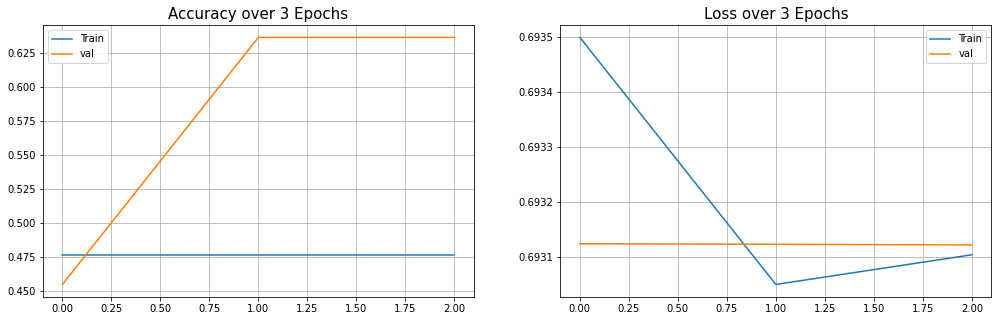

In [9]:
def accuracy_curve(h):
    acc, loss, val_acc, val_loss = h.history['accuracy'], h.history['loss'], h.history['val_accuracy'], h.history['val_loss']
    epoch = len(acc)
    plt.figure(figsize=(17, 5))
    
    plt.subplot(122)
    plt.plot(range(epoch), loss, label='Train')
    plt.plot(range(epoch), val_loss, label='val')
    plt.title('Loss over ' + str(epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    
    plt.subplot(121)
    plt.plot(range(epoch), acc, label='Train')
    plt.plot(range(epoch), val_acc, label='val')
    plt.title('Accuracy over ' + str(epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    

    plt.show()
    
accuracy_curve(history)

In [10]:
def plot_auc(y_test, y_score):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()

    for i in range(2):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_score[:, i])
        #print(thresholds)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return

def modelMetrics(y_test, y_score):
    y_prob= [ y[1] for y in y_score]
    #print(y_prob)
    sns.distplot(y_prob);
    y_prob_mean= np.mean(y_prob)
    print("mean: ", y_prob_mean)
    
    y_pred= [ int(y > y_prob_mean) for y in y_prob]
    accuracy= accuracy_score(y_test, y_pred)
    precision, recall, fscore, _= precision_recall_fscore_support(y_test, y_pred, average='binary')

    print("accuracy: %.2f%%" % (accuracy*100))
    print("precision: %.2f%%" % (precision*100))
    print("recall: %.2f%%" % (recall*100))
    print("fscore: %.2f%%" % (fscore*100))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

def valuationMetrics(model, X_test, y_test):
    y_prob = model.predict(X_test, batch_size=32, verbose=1)
    y_test_ = np.eye(2)[y_test]
    plot_auc(y_test_, y_prob)
    modelMetrics(y_test, y_prob)    

11/11 [==============================] - 0s 6ms/sample


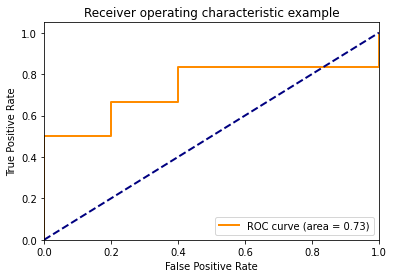

mean:  0.500016
accuracy: 72.73%
precision: 80.00%
recall: 66.67%
fscore: 72.73%
Confusion matrix:
[[4 1]
 [2 4]]


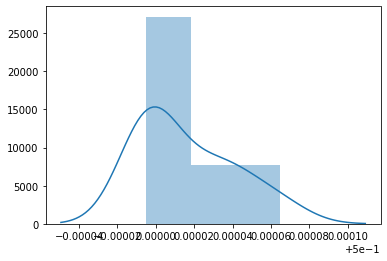

In [11]:
valuationMetrics(model, x_test, y_test)

In [12]:
path= 'model_save/model.h5'
model.save(path)
print(path)

model_save/model.h5
